# Testing degradation on ABC vs true distribution

In [25]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

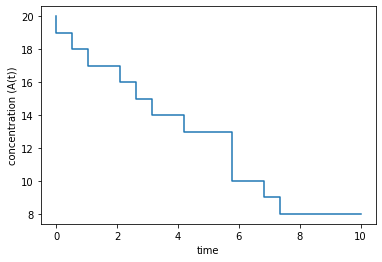

In [26]:
np.random.seed(2)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

In [27]:
np.random.seed(0)

from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 200)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=5.086995413811021e-16
posterior integrate value=0.9999392938746746


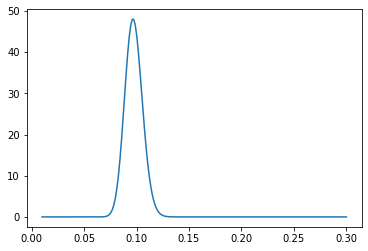

In [28]:
plt.plot(thetas, true_prob)
plt.show()

# Rejection ABC

In [29]:
np.random.seed(0)

abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(0.7)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1046   0.000956022945   0:00.5
2     1397   0.00143163923    0:00.7
3     2614   0.00114766641    0:01.3
20    19895  0.00100527771    0:08.1
40    42877  0.000932901089   0:16.7
60    73388  0.000817572355   0:29.1
80    97241  0.000822698245   0:38.4
100   110681  0.000903497439   0:43.4
120   132558  0.000905264111   0:51.6
140   158391  0.000883888605   1:01.9
160   178814  0.000894784525   1:10.5
180   211164  0.000852418026   1:22.5
200   237387  0.000842506119   1:32.1
220   262436  0.000838299624   1:42.1
240   285525  0.000840556869   1:50.6
260   321198  0.000809469548   2:03.8
280   348160  0.000804227941   2:14.0
300   379124  0.000791297834   2:25.5
320   406451  0.000787302775   2:36.1
340   430202  0.000790326405   2:45.7
360   461336  0.00078034231    2:58.6
380   491470  0.000773190632   3:10.3
400   507176  0.000788680852   3:17.6
420   535997  0.000783586475   3:29.5

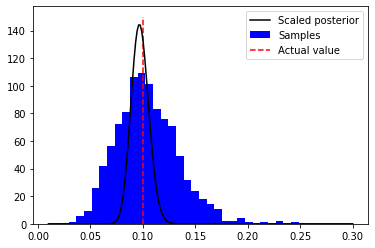

In [34]:
plt.hist(samples[:,0], 30, color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=150, label="Actual value", color="red")
mod_true_prob = [x * 3 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

# Compute Kernel Density Estimate

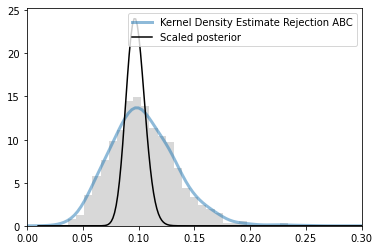

In [65]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for y in samples[:, 0] for x in y])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

# Save samples 

In [67]:
rej_abc_samples = samples

transf_samples = [x for y in samples[:, 0] for x in y]

print(transf_samples)

[0.08236422720534019, 0.10178792705852524, 0.14862222267015268, 0.12535874076487727, 0.1282667539522229, 0.12802938185552537, 0.13280479677759602, 0.11135752309729809, 0.10874753703947798, 0.1119494050662071, 0.12563008402922524, 0.13858492244511628, 0.09297479658263343, 0.11346175679890907, 0.09771545632863245, 0.08172476315317154, 0.0760038592284387, 0.10628029661612688, 0.09548408470473979, 0.1241595643723361, 0.05777665626257608, 0.057069730312707845, 0.10801465983137083, 0.07185434377957661, 0.14219572454720705, 0.06453438990325407, 0.09607347618995866, 0.09178225854971883, 0.16943272197104692, 0.12556987097215572, 0.09660067494396307, 0.10107166783413322, 0.08277157540697834, 0.10896963627515248, 0.09723980927858196, 0.05943635205539226, 0.12893912234451457, 0.1577562316587515, 0.08960639524698527, 0.06834083054931442, 0.07228280338227472, 0.17251222589222723, 0.12258000898510661, 0.08729846484075159, 0.09671612546686371, 0.07352804152034058, 0.11698606066076506, 0.08535337715252

# PMC Degradation (with smc)

In [86]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([0.9, 0.8, 0.7]))

# produce intermediate distributions of size 1000
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=0.8
Trying t=2, threshold=0.7
Iter. Eval. Acceptance rate Time m:s
1     276706  3.61394404e-06   6:38.6
2     277468  7.2080384e-06    6:40.2
3     277592  1.08072279e-05   6:40.4
20    285656  7.00142829e-05   6:54.8
40    302745  0.000132124395   7:19.5
60    318268  0.000188520366   7:30.9
80    332004  0.000240960952   7:40.1
100   341892  0.000292490026   7:46.8
120   352484  0.000340440985   7:53.9
140   366425  0.000382070001   8:15.9
160   375023  0.000426640499   8:30.6
180   387938  0.000463991669   8:55.7
200   407252  0.000491096422   9:32.0
220   418397  0.00052581639    9:50.5
240   426611  0.000562573398  10:05.1
260   439690  0.000591325707  10:28.8
280   454715  0.000615770318  10:57.0
300   466982  0.000642423048  11:19.8
320   477344  0.000670376081  11:39.3
340   487031  0.000698107513  11:57.1
360   496636  0.000724876972  12:15.0
380   510053  0.000745020616  12:40.7
400   522979  0.000764849067  13:

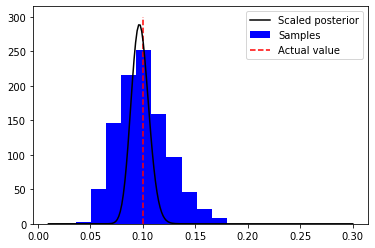

In [87]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

## Comput KDE

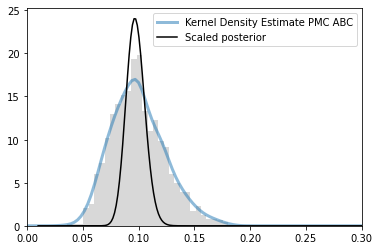

In [91]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for x in samples[:, 0]])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

## Save data

In [93]:
true_pmc_samples = samples[:, 0]
print(true_pmc_samples)

[0.13483937 0.06944909 0.13676759 0.15279609 0.08982677 0.16879974
 0.09951806 0.09412909 0.11833373 0.12037775 0.15355311 0.09046752
 0.08693453 0.10731102 0.13051183 0.08127951 0.15050703 0.08652541
 0.09296141 0.13979808 0.09486236 0.0971014  0.12133723 0.10604816
 0.08200857 0.13481587 0.15924984 0.08243267 0.15293088 0.12814093
 0.07466803 0.10486608 0.08529969 0.14193043 0.12815445 0.07848743
 0.07200675 0.09048088 0.0593402  0.12453459 0.11240901 0.07895269
 0.11384015 0.17131862 0.06698876 0.15453346 0.10298162 0.12748119
 0.09580494 0.0721323  0.08325862 0.1097412  0.12163716 0.15217437
 0.11498349 0.06714661 0.0940738  0.10019471 0.13895821 0.12559765
 0.089281   0.1087544  0.11184234 0.11674313 0.11315508 0.13766795
 0.11819898 0.1226559  0.15339671 0.07323743 0.0860173  0.10093055
 0.07578074 0.14308813 0.07550207 0.12115882 0.0856314  0.13724077
 0.16614089 0.11479523 0.10433545 0.06925748 0.09330803 0.08416244
 0.09000958 0.08659663 0.0775645  0.1217464  0.12429618 0.1003

# True PMC

In [13]:
np.random.seed(3)

abc = pints.ABCController(error_measure, log_prior, method=pints.ABCPMC)

# set the threshold
abc.sampler().set_threshold(1)

# set target number of samples
# try this
abc.set_n_samples(500)

# setting the number of generations
abc.sampler().set_n_generations(20)

# setting the threshold ratio
abc.sampler().set_t_ratio(0.99)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using PMC ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     465899  0.00107534036   18:42.1
Halting: target number of samples (501) reached.
Done


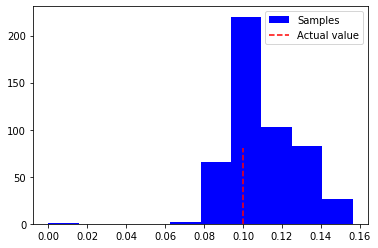

In [14]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=80, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

# ABC SMC

In [73]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([0.9, 0.8, 0.7]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=0.8
Trying t=2, threshold=0.7
Iter. Eval. Acceptance rate Time m:s
1     51648  1.9361834e-05    0:26.3
2     51651  3.87214188e-05   0:26.3
3     51717  5.80080051e-05   0:26.4
20    62259  0.000321238696   0:32.1
40    74313  0.00053826383    0:38.6
60    85712  0.000700018667   0:44.8
80    95452  0.000838117588   0:50.4
100   111562  0.000896362561   0:59.0
120   117902  0.00101779444    1:02.3
140   130093  0.00107615321    1:08.5
160   142018  0.00112661775    1:14.6
180   155562  0.00115709492    1:21.5
200   165700  0.0012070006     1:26.7
220   175339  0.0012547123     1:31.6
240   184885  0.00129810423    1:36.5
260   196510  0.00132308788    1:42.3
280   211841  0.00132174603    1:50.1
300   222159  0.00135038418    1:55.8
320   235376  0.00135952688    2:03.5
340   247260  0.00137507078    2:09.6
360   255997  0.00140626648    2:14.1
380   267954  0.00141815386    2:20.2
400   283026  0.00141329772    2:27.8
42

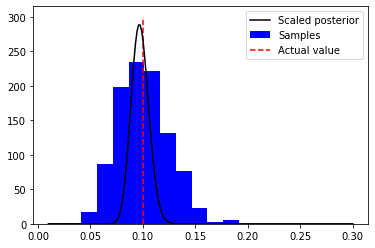

In [74]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

## Compute KDE

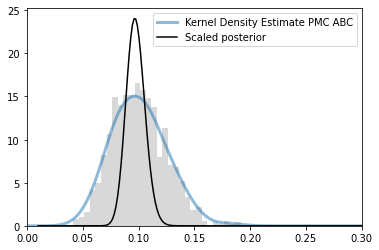

In [75]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for x in samples[:, 0]])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

## Save data

In [76]:
pmc_fake_samples = samples[:, 0]
print(pmc_fake_samples)

[0.10107164 0.11288636 0.07236055 0.06431273 0.08698871 0.09234446
 0.10085307 0.10407369 0.09920432 0.1094827  0.11084937 0.10077363
 0.12650915 0.07421346 0.12835746 0.12604512 0.0829669  0.05528263
 0.08491751 0.06526128 0.08515942 0.08862808 0.11448484 0.12883448
 0.12531988 0.12213006 0.12214313 0.08636    0.10002606 0.08741427
 0.09294142 0.1234703  0.12740868 0.10601722 0.08188376 0.13647165
 0.10081018 0.09332732 0.09288564 0.09244748 0.08787108 0.07981085
 0.1228482  0.13194194 0.12266544 0.06907743 0.10921927 0.12722043
 0.1031403  0.07533078 0.10519619 0.10103704 0.10326417 0.12556203
 0.08902892 0.10823901 0.07744848 0.09103697 0.12899555 0.08875035
 0.11103464 0.12998517 0.13065204 0.08407433 0.06819056 0.13918387
 0.09958318 0.10736903 0.107777   0.08401324 0.08831588 0.09622122
 0.06062578 0.08821703 0.13387058 0.12057147 0.07658911 0.08482433
 0.08945238 0.1130154  0.09944088 0.09761936 0.07025113 0.09036566
 0.11236135 0.0770997  0.11423499 0.11514078 0.07391843 0.0753

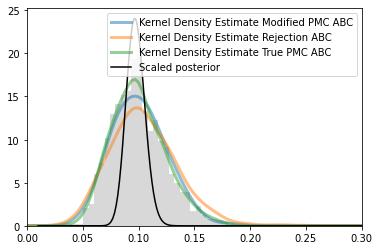

In [94]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = pmc_fake_samples
p_samples = np.array([x for z in rej_abc_samples for y in z for x in y])
r_samples = true_pmc_samples

# print(p_samples)

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(p_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(r_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate True PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

# Adaptive PMC ABC

In [95]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(700)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.13035069]
epsilon=4.2485291572496005
w_mean=[0.11521002]
epsilon=3.391164991562634
w_mean=[0.1138805]
epsilon=2.8284271247461903
w_mean=[0.1098596]
epsilon=2.4289915602982237
w_mean=[0.11106907]
epsilon=2.1908902300206647
w_mean=[0.1127796]
epsilon=2.0124611797498106
w_mean=[0.11052584]
epsilon=1.8841443681416772
w_mean=[0.11106384]
epsilon=1.8027756377319946
w_mean=[0.10893368]
epsilon=1.7175564037317668
w_mean=[0.10918697]
epsilon=1.6431676725154984
w_mean=[0.10962249]
epsilon=1.5652475842498528
w_mean=[0.10994826]
epsilon=1.5165750888103102
w_mean=[0.109192]
epsilon=1.466287829861518
w_mean=[0.1089366]
epsilon=1.449137674618944
w_mean=[0.10884178]
epsilon=1.4317821063276355
w_mean=[0.10876665]
epsilon=1.3964240043768943
w_mean=[0.10954842]
epsilon=1.3601470508735443
w_mean=[0.10979573]
epsilon=1.3416407864998738
w_mean=[0.10951811]
epsilon=1.3228756555322954
w_mean=[0.10851298]
epsilon=1.3038404810405297
w_mean=

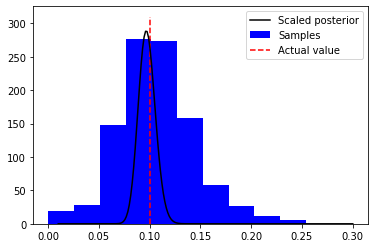

In [96]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=310, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

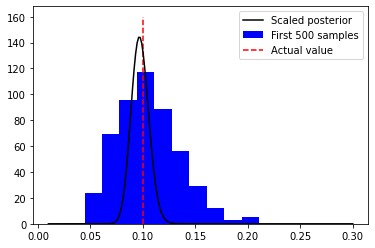

In [97]:
plt.hist(samples[:500,0], color="blue", label="First 500 samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=160, label="Actual value", color="red")
mod_true_prob = [x * 3 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

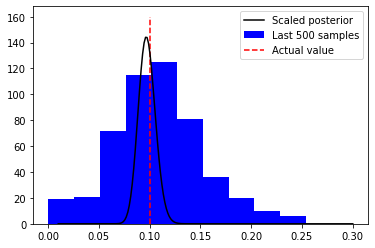

In [98]:
plt.hist(samples[500:,0], color="blue", label="Last 500 samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=160, label="Actual value", color="red")
mod_true_prob = [x * 3 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

## Compute KDE

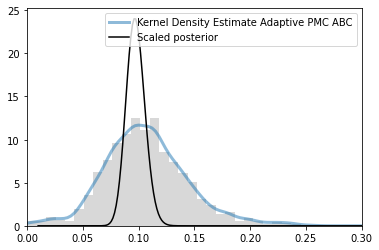

In [107]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for x in samples[:, 0]])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

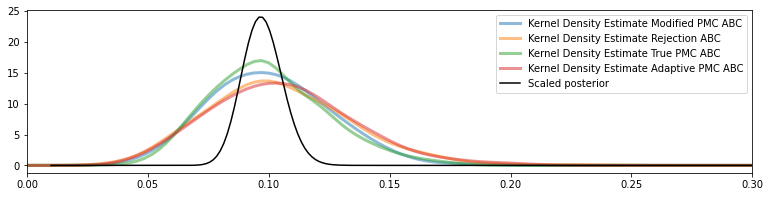

In [115]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(13, 3))

t_samples = pmc_fake_samples
p_samples = np.array([x for z in rej_abc_samples for y in z for x in y])
r_samples = true_pmc_samples
w_samples = samples[:700, 0]

# print(p_samples)

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(p_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(r_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate True PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(w_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
# ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')